This notebook documents the filtering steps that were applied to the public mouse RRBS datasets. Most of these scripts here are an example of scripts. This was mostly processed on a parallel computing infrastructure or using shell scripts. Thus, the goal of this notebook is to outline and document which scripts were used so that one could recreate in their own environment.


# Public Mice RRBS

## Outline describing operations conducted in a parralel computing environment

### GEO and SRA data sequencing alignment

GEO studies used in this section include GSE60012 (Reizel et al., 2015), GSE52266 (Cannon et al., 2015) and GSE67507 (Orozco et al., 2015)

GEO data and SRA data were downloaded and aligned to a bisulfite-converted Ensembl mm10 genome with the script, 'script/methPipe.py' This script will not work out of the box and has to be configured according to the comments in the script itself.

### Collapsing multiple sequencing runs associated with the same sample

Sometimes, samples are split into multiple runs. We used the meta_tables to collapse SRR (run ids) into SRS (sample ids). This was done using a parralel computing framework, with script 'script/script_to_sortMerge_singleSRRs_generic.py'. Briefly, this script takes as input the directory containing the SRR*.bismark.cov files, the meta_table obtained from GEO or SRA, and the SRS_ID to rename the file (These meta tables can be found in data/meta_data). THe script then concatenates the bismark.cov alignments associated with an SRS ID, then sorts using sort -k1,1 -k2,2n, and then uses mergeBed (bedtools) to add the number of reads supporting the methylated or unmethylated allele at overlapping sites. 

### Scripts for determining which sites were covered across all

In order to find sites that were commonly profiled across our RRBS studies, we used the script 'scripts/counts_sites_per_sample_zeros_list.py'. This script takes as input the SRS*.bismark.cov file (zero-based), a file describing the length of chromosomes (tab delimited), The directory to write out results and the sample identifier. This script will create a dictionary indexed by the chromosome, with a vector of zeros of length chromosome. It then reads the bismark.cov file, and adds a 1 to the appropriate index. The script will then create a file for each chromosome consisting of the sites that are profiled per chromosome.

Next, after all files have been processed, a second script then adds the resulting array to find sites that are commonly profiled across samples. This was also done in a parallel computing environment, using the script 'script/collapse_coverage_per_chrm_basebed_input.py'. This script takes as input, the directory where the output of the previous script resides, the chromosome, the percent of total samples required to be covered, a directory to write the output, and a genome file (identical to that used in the first section), and a single column file describing which specific samples to include in the counting. It is in this step that I have reduced the chromosome space to search to those aligning to 1-19. The script will then create a zeros vector as long as the chromosome, and find the files corresponding to the sample-chromosome generated by the previous script, and adds it to the total count. This vector describing the positions and the counts are then filtered by the percent filter, and a file is written with acceptable sites for that chromosome in the format of 'chr:start:stop', in zero-based form. It also saves the count vector itself in numpy format. When using this script, I chose ~30% to reduce the space, yet leave enough room for other filters to apply later. 

Next, after sites for each chromosome have been identified, we then concatenated the file with the sites and sorted it, creating a file that is a single column file describing the chr:start:stop to consider (site2index_file). This is used as input to the next script, 'script/create_sample_by_site_matrix_srsidsysargv.py'. Inputs include the site2index_file, the bismark.cov file, the file to write out (in hdf format), and the srs id. This site2index_file is then used to create a dictionary that is keyed by the site and associated with the number in the sorted site2index file. It also creates two vectors that is equal to the length of the sites kept, one for the methylation value and one for the number of reads supporting that site. The script then reads the bismark.cov file to keep the sites indicated by the site2index_file. The script also checks if the methylation value is represented by a fraction or by a percent, if by a percent, the value is converted to a fraction. These values are then recorded into the vectors using the index corresponding to the site. Both vectors are then converted to a pandas dataframe, where the columns correspond to the sitenames, and the index is recorded by the srs_id. This file is then saved as an hdf file where the sheets correspond to the values and reads.

Finally, the resulting pandas dataframes are concatenated for the samples considered into a single dataframe. This is accomplished using 'scripts/make_df_1x1x.py.' This script takes as input the directory where the hdf files where the saved. This is then used to concatenate the different dataframes (warning may require large ram due to the number of sites kept), and then creates a unified dataframe with all samples and the methylation values, and a dataframe describing the reads supporting that site in the same directory. The single sample dataframes are then deleted, and this is used as input for further filtering steps described below.

## Filtering for final sites.

### Notebook imports

In [1]:
from __future__ import division
import os
import subprocess
import csv
import imp
import re
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
%matplotlib inline
import collections
twto = imp.load_source('twto','scripts/twang_toolbox.py')
meth = imp.load_source('meth','scripts/methy_parsing.py')
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hac
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn import datasets
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats as smstats
from sklearn import cross_validation, linear_model, metrics

/cellar/users/twang/anaconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [2]:
sns.set(context='notebook',style='ticks')

#### Apply sites to filter reads and remove samples with too much missing data

In [3]:
hdffile = 'data/evolutionary_trends/preprocessing/Full_Liver_df_firstpasssites.h5'
methy_raw = pd.read_hdf(hdffile,'raw_methy_vals')
methy_reads = pd.read_hdf(hdffile,'reads')

In [4]:
methy_reads_filter = methy_reads >= 5

In [5]:
methy_raw_read_filtered = methy_raw[methy_reads_filter]

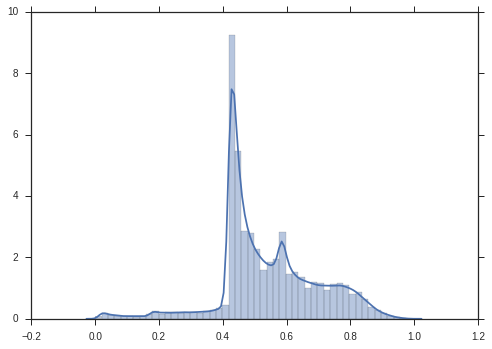

In [6]:
nulls_per_site = methy_raw_read_filtered.isnull().sum()/methy_raw_read_filtered.shape[0]
sns.distplot(nulls_per_site)

In [7]:
keep_sites = nulls_per_site[nulls_per_site<0.2].index

In [8]:
methy_raw_read_filtered_keepsites = methy_raw_read_filtered[keep_sites]

In [9]:
nulls_per_sample = methy_raw_read_filtered_keepsites.isnull().sum(axis=1)/keep_sites.shape[0]

In [10]:
keep_samples = nulls_per_sample[nulls_per_sample<0.4].index

In [11]:
keep_samples.shape

(231,)

In [12]:
methy_raw_read_filtered_keepsites_keepsamples = methy_raw_read_filtered_keepsites.loc[keep_samples]

In [13]:
methy_raw_read_filtered_keepsites_keepsamples_imputed = methy_raw_read_filtered_keepsites_keepsamples.fillna(methy_raw_read_filtered_keepsites_keepsamples.mean())

#### load relevant covariate data

In [14]:
covariates_public_file = 'data/meta_data/PublicRRBSData_RelevantCovariates.txt'
covariates = pd.read_csv(covariates_public_file,sep='\t',index_col=0,header=0)

#### save imputed data

In [15]:
df_dict = {'methy_mat':methy_raw_read_filtered_keepsites_keepsamples_imputed,'covariates':covariates.loc[keep_samples],
          'reads':methy_reads.loc[keep_samples,keep_sites],'raw_methy_mat':methy_raw_read_filtered_keepsites_keepsamples}
outhdf = 'data/evolutionary_trends/RRBS_MethylationData_Public.h5'
twto.save_hdf_file(df_dict,outhdf)

In [16]:
outhdf = 'data/evolutionary_trends/RRBS_MethylationData_Public.h5'
covariates = pd.read_hdf(outhdf,'covariates')
methy_mat = pd.read_hdf(outhdf,'methy_mat')

#### save sites for bed file

In [17]:
bed_format = sorted([x.split(':')+[x] for x in methy_mat.columns])
outf = 'data/evolutionary_trends/PublicRRBS_considered_sites.bed'
twto.write_file(bed_format,outf)

# Human

Human data was downloaded from GEO using accession numbers GSE61258 and GSE48325 corresponding to Horvath et al.and Ahrens et al. datasets. R packages needed include, impute, WGCNA, and minfi and all other dependencies. The BMIQ based normalization was downloaded from Horvath's epigenetic clock paper (PMID: 24138928). It can also be found in 'scripts/NORMALIZATION.R'

The following R cell shows the data-processing to process these two datasets.

In [ ]:
#Download data
%%R
library(minfi)
gse_data<- getGenomicRatioSetFromGEO(GSE = 'GSE61258')
beta_values<-getBeta(gse_data)
write.csv(beta_values, file = 'data/evolutionary_trends/human_liver/beta_values_GSE61258.csv')
gse_data <- getGenomicRatioSetFromGEO(GSE = 'GSE48325')
beta_values<-getBeta(gse_data)
write.csv(beta_values, file = 'data/evolutionary_trends/human_liver/beta_values_GSE48325.csv')

In [ ]:
#Normalize data
%%R
library(impute)
source('scripts/NORMALIZATION.R')
gse2<-read.table('data/evolutionary_trends/human_liver/beta_values_GSE61258.csv',header=TRUE,sep=',',row.names=1)
gse1<-read.table('data/evolutionary_trends/human_liver/beta_values_GSE48325.csv',header=TRUE,sep=',',row.names=1)
gse_mat<-data.matrix(gse1)
gse_mat2<-data.matrix(gse2)
gs<-rowMeans(gse_mat2,na.rm=TRUE)
new<-cbind(gse_mat,gse_mat2)
#new[is.na(new)]<-rowMeans(which(is.na(new),arr.ind=TRUE),na.rm=TRUE)
new_transpose<-t(new)
datMeth<-new_transpose
dimnames1=dimnames(datMeth)
datMeth= data.frame(t(impute.knn(as.matrix(t(datMeth)))$data))
dimnames(datMeth)=dimnames1
gold.mean=as.numeric(apply(datMeth,2,mean,na.rm=TRUE))
data_n <- BMIQcalibration(datMeth, gold.mean)

In [ ]:
#Save to hdffile
%Rpull data_n

In [ ]:
#Load covariates
human_covs_f = 'data/meta_data/HumanLiverCovariates.txt'
human_covs = pd.read_csv(human_covs_f,sep='\t',header=0,index_col=0)

In [ ]:
hdfhuman = 'data/HumanLiverData_BMIQNormed.h5'
twto.save_hdf_file({'methy_mat':data_n,'covariates':human_covs})